# Lab 6: The Lorentz equations

##  List of Problems 

[Problem Experiment:  Investigation of the behaviour of solutions](#prob_experiment)

[Problem Steady-states: Find the stationary points of the Lorenz system](#prob_steady-states)

[Problem Eigenvalues: Find the eigenvalues of the stationary point (0,0,0)](#prob_eigenvalues)

[Problem Stability: Discuss the effect of r on the stability of the solution](#prob_stability)

[Problem Adaptive: Adaptive time-stepping for the Lorenz equations](#prob_adaptive)

[Problem Sensitivity: Sensitivity to initial conditions](#prob_sensitivity)

<!-- {#lab6:sec:objectives} -->

<div id="sec_objectives"></div>

## Objectives 

In this lab, you will investigate the transition to chaos in the Lorenz
equations – a system of non-linear ordinary differential equations.
Using interactive examples, and analytical and numerical techniques, you
will determine the stability of the solutions to the system, and
discover a rich variety in their behaviour. You will program both an
adaptive and non-adaptive Runge-Kuttan code for the problem, and
determine the relative merits of each.

<div id="sec_readings"></div>

## Readings

There is no required reading for this lab, beyond the contents of the
lab itself. Nevertheless, the original 1963 paper by Lorenz  is
worthwhile reading from a historical standpoint.

If you would like additional background on any of the following topics,
then refer to Appendix B for the following:

-   **Easy Reading:**

    -   Gleick  (1987) [pp. 9-31], an interesting overview of the
        science of chaos (with no mathematical details), and a look at
        its history.

    -   Palmer (1993) has a short article on Lorenz’ work and
        concentrating on its consequences for weather prediction.

-   **Mathematical Details:**

    -   Sparrow (1982), an in-depth treatment of the mathematics
        behind the Lorenz equations, including some discussion of
        numerical methods.
        
    -   The original equations by Saltzman (1962) and the
        first Lorentz (1963) paper on the computation.






<!-- {#lab6:sec:intro} -->

<div id="sec_introduction"></div>

##  Introduction 


For many people working in the physical sciences, the *butterfly
effect* is a well-known phrase. But even if you are unacquainted
with the term, its consequences are something you are intimately
familiar with. Edward Lorenz investigated the feasibility of performing
accurate, long-term weather forecasts, and came to the conclusion that
*even something as seemingly insignificant as the flap of a
butterfly’s wings can have an influence on the weather on the other side
of the globe*. This implies that global climate modelers must
take into account even the tiniest of variations in weather conditions
in order to have even a hope of being accurate. Some of the models used
today in weather forecasting have up to *a million unknown
variables!*

With the advent of modern computers, many people believed that accurate
predictions of systems as complicated as the global weather were
possible. Lorenz’ studies (Lorenz, 1963), both analytical and numerical, were
concerned with simplified models for the flow of air in the atmosphere.
He found that even for systems with considerably fewer variables than
the weather, the long-term behaviour of solutions is intrinsically
unpredictable. He found that this type of non-periodic, or
*chaotic* behaviour, appears in systems that are described
by non-linear differential equations.

The atmosphere is just one of many hydrodynamical systems, which exhibit
a variety of solution behaviour: some flows are steady; others oscillate
between two or more states; and still others vary in an irregular or
haphazard manner. This last class of behaviour in a fluid is known as
*turbulence*, or in more general systems as
*chaos*. Examples of chaotic behaviour in physical systems
include

-   thermal convection in a tank of fluid, driven by a heated plate on
    the bottom, which displays an irregular patter of “convection rolls”
    for certain ranges of the temperature gradient;

-   a rotating cylinder, filled with fluid, that exhibits
    regularly-spaced waves or irregular, nonperiodic flow patterns under
    different conditions;

-   the Lorenzian water wheel, a mechanical system, described in
    [Appendix A](#sec_water-wheel).



One of the simplest systems to exhibit chaotic behaviour is a system of
three ordinary differential equations, studied by Lorenz, and which are
now known as the *Lorenz equations* (see
equations ([eq: lorentz](#eq_lorentz)). They are an idealization of
a more complex hydrodynamical system of twelve equations describing
turbulent flow in the atmosphere, but which are still able to capture
many of the important aspects of the behaviour of atmospheric flows. The
Lorenz equations determine the evolution of a system described by three
time-dependent state variables, $x(t)$, $y(t)$ and $z(t)$. The state in
Lorenz’ idealized climate at any time, $t$, can be given by a single
point, $(x,y,z)$, in *phase space*. As time varies, this
point moves around in the phase space, and traces out a curve, which is
also called an *orbit* or *trajectory*. 

The video below shows an animation of the 3-dimensional phase space trajectories
of $x, y, z$ for the Lorenz equations presented below.  It is calculated with
the python script by written by Jake VanderPlas: [lorenz_ode.py](https://github.com/phaustin/numeric/blob/lab6/lab6/lorenz_ode.py)

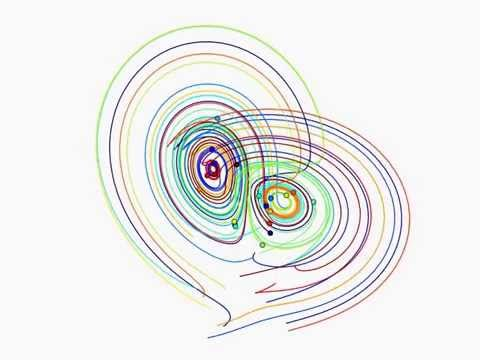

In [1]:
from IPython.display import YouTubeVideo
YouTubeVideo('DDcCiXLAk2U')

<div id="sec_using"></div>


## Using the Integrator class

 [lorenz_ode.py](https://github.com/phaustin/numeric/blob/lab6/lab6/lorenz_ode.py) uses the
 odeint package from scipy.  That's fine if we are happy with a black box, but we
 can also use the Integrator class from lab 5.   Here is the sub-class Integrator61 
 that is specified for the Lorenz equations:

In [2]:
import context
from numlabs.lab5.lab5_funs import Integrator
from collections import namedtuple
import numpy as np



class Integ61(Integrator):
   
    def __init__(self, coeff_file_name,initvars=None,uservars=None,
                timevars=None):
        super().__init__(coeff_file_name)
        self.set_yinit(initvars,uservars,timevars)
        
    def set_yinit(self,initvars,uservars,timevars):
        #
        # read in 'sigma beta rho', override if uservars not None
        #
        if uservars:
            self.config['uservars'].update(uservars)
        uservars = namedtuple('uservars', self.config['uservars'].keys())
        self.uservars = uservars(**self.config['uservars'])
        #
        # read in 'x y z'
        #
        if initvars:
            self.config['initvars'].update(initvars)
        initvars = namedtuple('initvars', self.config['initvars'].keys())
        self.initvars = initvars(**self.config['initvars'])
        #
        # set dt, tstart, tend if overiding base class values
        #
        if timevars:
            self.config['timevars'].update(timevars)
            timevars = namedtuple('timevars', self.config['timevars'].keys())
            self.timevars = timevars(**self.config['timevars'])
        self.yinit = np.array(
            [self.initvars.x, self.initvars.y, self.initvars.z])
        self.nvars = len(self.yinit)
    
    def derivs5(self, coords, t):
        x,y,z = coords
        u=self.uservars
        f=np.empty_like(coords)
        f[0] = u.sigma * (y - x)
        f[1] = x * (u.rho - z) - y
        f[2] = x * y - u.beta * z
        return f

******************************
context imported. Front of path:
/Users/phil/repos/numeric
back of path: /Users/phil/.ipython
******************************

through /Users/phil/repos/numeric/notebooks/lab6/context.py


The main difference with daisyworld is that I've changed the ```__init__``` function to
take optional arguments to take initvars, uservars and timevars, to give us
more flexibility in overriding the default configuration specified in
[lorenz.yaml](./lorenz.yaml)

I also want to be able to plot the trajectories in 3d, which means that I
need the Axes3D class from matplotlib.  I've written a convenience function
called plot_3d that sets start and stop points and the viewing angle:

In [3]:
import warnings
warnings.simplefilter(action = "ignore", category = FutureWarning)
%matplotlib inline
from matplotlib import pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
plt.style.use('ggplot')

def plot_3d(ax,xvals,vals,zvals):
    """
        plot a 3-d trajectory with start and stop markers
    """
    line,=ax.plot(xvals,yvals,zvals,'r-')
    ax.set_xlim((-20, 20))
    ax.set_ylim((-30, 30))
    ax.set_zlim((5, 55))
    ax.grid(True)
    #
    # look down from 30 degree elevation and an azimuth of
    #
    ax.view_init(30,5)
    line,=ax.plot(xvals,yvals,zvals,'r-')
    ax.plot([-20,15],[-30,-30],[0,0],'k-')
    ax.scatter(xvals[0],yvals[0],zvals[0],marker='o',c='green',s=75)
    ax.scatter(xvals[-1],yvals[-1],zvals[-1],marker='^',c='blue',s=75)
    out=ax.set(xlabel='x',ylabel='y',zlabel='z')
    line.set(alpha=0.2)
    return ax



In the code below I set timevars, uservars and initvars
to illustrate a sample orbit in phase
space (with initial value $(5,5,5)$). Notice that the orbit appears to
be lying in a surface composed of two “wings”. In fact, for the
parameter values used here, all orbits, no matter the initial
conditions, are eventually attracted to this surface; such a surface is
called an *attractor*, and this specific one is termed the
*butterfly attractor* … a very fitting name, both for its
appearance, and for the fact that it is a visualization of solutions
that exhibit the “butterfly effect.” The individual variables are
plotted versus time in [Figure xyz-vs-t](#fig_xyz-vs-t).

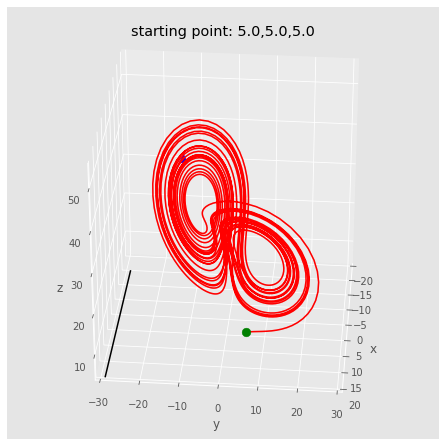

In [4]:
#
# make a nested dictionary to hold parameters
#
timevars=dict(tstart=0,tend=27,dt=0.01)
uservars=dict(sigma=10,beta=2.6666,rho=28)
initvars=dict(x=5,y=5,z=5)
params=dict(timevars=timevars,uservars=uservars,initvars=initvars)
#
# expand the params dictionary into key,value pairs for
# the Integ61 constructor using dictionary expansion
#
theSolver = Integ61('lorenz.yaml',**params)
timevals, coords, errorlist = theSolver.timeloop5fixed()
xvals,yvals,zvals=coords[:,0],coords[:,1],coords[:,2]


fig = plt.figure(figsize=(6,6))
ax = fig.add_axes([0, 0, 1, 1], projection='3d')
ax=plot_3d(ax,xvals,yvals,zvals)
out=ax.set(title='starting point: {},{},{}'.format(*coords[0,:]))
#help(ax.view_init)

<!-- ="lab6:fig:fixed-plot" -->

A plot of the solution to the Lorenz equations as an orbit in phase
space. Parameters: $\sigma=10$, $\beta=\frac{8}{3}$, $\rho=28$; initial values:
$(x,y,z)=(5,5,5)$.

<div id="fig_xyz-vs-t"></div>

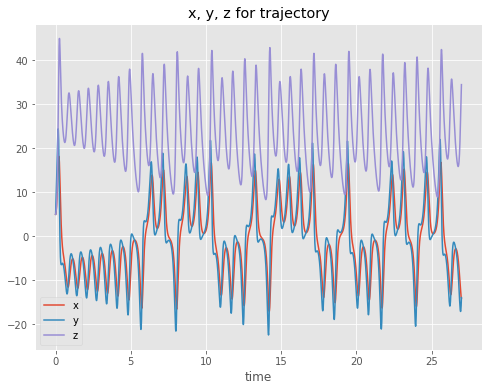

In [5]:
fig,ax = plt.subplots(1,1,figsize=(8,6))
ax.plot(timevals,xvals,label='x')
ax.plot(timevals,yvals,label='y')
ax.plot(timevals,zvals,label='z')
ax.set(title='x, y, z for trajectory',xlabel='time')
out=ax.legend()

<!-- data-label="lab6:fig:xyz-vs-t"> -->

**Figure xyz-vs-t**: A plot of the solution to the Lorenz equations versus time.
Parameters: $\sigma=10$, $\beta=\frac{8}{3}$, $\rho=28$; initial values:
$(x,y,z)=(5,5,5)$.


As you saw in the movie, the behaviour of the solution, even though it
seems to be confined to a specific surface, is anything but regular. The
solution seems to loop around and around forever, oscillating around one
of the wings, and then jump over to the other one, with no apparent
pattern to the number of revolutions. This example is computed for just
one choice of parameter values, and you will see in the problems later
on in this lab, that there are many other types of solution behaviour.
In fact, there are several very important characteristics of the
solution to the Lorenz equations which parallel what happens in much
more complicated systems such as the atmosphere:

1.  The solution remains within a bounded region (that is, none of the
    values of the solution “blow up”), which means that the solution
    will always be physically reasonable.

2.  The solution flips back and forth between the two wings of the
    butterfly diagram, with no apparent pattern. This “strange” way that
    the solution is attracted towards the wings gives rise to the name
    <span>*strange attractor*</span>.

3.  The resulting solution depends very heavily on the given initial
    conditions. Even a very tiny change in one of the initial values can
    lead to a solution which follows a totally different trajectory, if
    the system is integrated over a long enough time interval.

4.  The solution is irregular or <span>*chaotic*</span>, meaning that it
    is impossible, based on parameter values and initial conditions
    (which may contain small measurement errors), to predict the
    solution at any future time.



<!-- {#lab6:sec:equations} -->

<div id="sec_lorenz"></div>
##  The Lorenz Equations 


As mentioned in the previous section, the equations we will be
considering in this lab model an idealized hydrodynamical system:
two-dimensional convection in a tank of water which is heated at the
bottom (as pictured in [Figure Convection](#fig_convection) below).

<div id="fig_convection"></div>

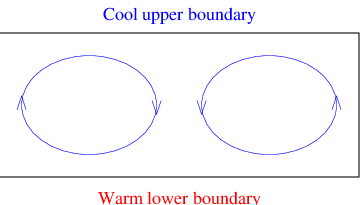

In [6]:
from IPython.display import Image
Image(filename="images/convection.png")

**Figure Convection** Lorenz studied the flow of fluid in a tank heated at the bottom, which
results in “convection rolls”, where the warm fluid rises, and the cold
fluid is drops to the bottom.

Lorenz wrote the equations in the form

<!-- \label{lab6:eq:lorenz} -->

<div id="eq_lorenz"></div>
$$
\begin{aligned}
  \frac{dx}{dt} &=& \sigma(y-x)  \\
  \frac{dy}{dt} &=& \rho x-y-xz  \\
  \frac{dz}{dt} &=& xy-\beta z 
\end{aligned}
$$
where $\sigma$, $\rho$
and $\beta$ are real, positive parameters. The variables in the problem can
be interpreted as follows:

-   $x$ is proportional to the intensity of the convective motion (positive
    for clockwise motion, and a larger magnitude indicating more
    vigorous circulation),

-   $y$ is proportional to the temperature difference between the ascending
    and descending currents (it’s positive if the warm water is on the
    bottom),

-   $z$ is proportional to the distortion of the vertical temperature
    profile from linearity (a value of 0 corresponds to a linear
    gradient in temperature, while a positive value indicates that the
    temperature is more uniformly mixed in the middle of the tank and
    the strongest gradients occur near the boundaries),

-   $t$ is the dimensionless time,

-   $\sigma$ is called the Prandtl number (it involves the viscosity and thermal
    conductivity of the fluid),

-   $\rho$ is a control parameter, representing the temperature difference
    between the top and bottom of the tank, and

-   $\beta$ measures the width-to-height ratio of the convection layer.

Notice that these equations are *non-linear* in $x$, $y$
and $z$, which is a result of the non-linearity of the fluid flow
equations from which this simplified system is obtained.

**Mathematical Note**: This system of equations is derived by Saltzman (1962) for the
thermal convection problem. However, the same
equations ([eq:lorenz](#eq_lorenz)) arise in other physical
systems as well. One example is the whose advantage over the original
derivation by Saltzman (which is also used in Lorenz’ 1963 paper ) is
that the system of ODEs is obtained *directly from the
physics*, rather than as an approximation to a partial
differential equation.

Remember from Section [lab6:sec:intro] that the Lorenz equations exhibit
nonperiodic solutions which behave in a chaotic manner. Using analytical
techniques, it is actually possible to make some qualitative predictions
about the behaviour of the solution before doing any computations.
However, before we move on to a discussion of the stability of the
problem in Section [lab6:sec:stability], you should do the following
exercise, which will give you a hands-on introduction to the behaviour
of solutions to the Lorenz equations.

<div id="prob_experiment"></div>

[Problem Experiment](#prob_experiment) Lorenz’ results are based on the following values
of the physical parameters taken from Saltzman’s paper (Saltzman, 1962):
$$\sigma=10 \quad \mathrm{and} \quad b=\frac{8}{3}.$$ As you will see
in [Section stability](#sec_stability), there is a *critical value of the
parameter $\rho$*, $\rho^\ast=470/19\approx 24.74$ (for these values of
$\sigma$ and $\beta$); it is *critical* in the sense that for
any value of $\rho>\rho^\ast$, the flow is unstable.

To allow you to investigate the behaviour of the solution to the Lorenz
equations, you can try out various parameter values in the following
interactive example. *Initially, leave $\sigma$ and $\beta$ alone, and
modify only $\rho$ and the initial conditions.* If you have time,
you can try varying the other two parameters, and see what happens. Here
are some suggestions:

-   Fix the initial conditions at $(5,5,5)$ and vary $\rho$ between $0$ and
    $100$.

-   Fix $\rho=28$, and vary the initial conditions; for example, try
    $(0,0,0)$, $(0.1,0.1,0.1)$, $(0,0,20)$, $(100,100,100)$,
    $(8.5,8.5,27)$, etc.

-   Anything else you can think of …

1.  Describe the different types of behaviour you see and compare them
    to what you saw in [Figure fixed-plot](#fig_fixed-plot). Also, discuss the
    results in terms of what you read in [Section Introduction](#sec_introduction)
    regarding the four properties of the solution.

2.  One question you should be sure to ask yourself is: *Does
    changing the initial condition affect where the solution ends
    up?* The answer to this question will indicate whether there
    really is an attractor which solutions approach as
    $t\rightarrow\infty$.

3.  Finally, for the different types of solution behaviour, can you
    interpret the results physically in terms of the thermal convection
    problem?
 
Now, we’re ready to find out why the solution behaves as it does. In
[Section Intro](#sec_introduction), you were told about four properties of
solutions to the Lorenz equations that are also exhibited by the
atmosphere, and in the problem you just worked though, you saw that
these were also exhibited by solutions to the Lorenz equations. In the
remainder of this section, you will see mathematical reasons for two of
those characteristics, namely the boundedness and stability (or
instability) of solutions.




<div id="sec_boundedness"></div>

##  Boundedness of the Solution


The easiest way to see that the solution is bounded in time is by
looking at the motion of the solution in phase space, $(x,y,z)$, as the
flow of a fluid, with velocity $(\dot{x}, \dot{y}, \dot{z})$ (the “dot”
is used to represent a time derivative, in order to simplify notation in
what follows). The *divergence of this flow* is given by
$$\frac{\partial \dot{x}}{\partial x} +
  \frac{\partial \dot{y}}{\partial y} +
  \frac{\partial \dot{z}}{\partial z},$$ and measures how the volume of
a fluid particle or parcel changes – a positive divergence means that
the fluid volume is increasing locally, and a negative volume means that
the fluid volume is shrinking locally (zero divergence signifies an
*incompressible fluid*, which you will see more of in and
). If you look back to the Lorenz
equations ([eq:lorenz](#eq_lorenz)), and take partial derivatives,
it is clear that the divergence of this flow is given by
$$
\frac{\partial \dot{x}}{\partial x} +
\frac{\partial \dot{y}}{\partial y} +
\frac{\partial \dot{z}}{\partial z} = -(\sigma + b + 1).
$$
Since
$\sigma$ and $b$ are both positive, real constants, the divergence is a
negative number, which is always less than $-1$. Therefore, each small
volume shrinks to zero as the time $t\rightarrow\infty$, at a rate which
is independent of $x$, $y$ and $z$. The consequence for the solution,
$(x,y,z)$, is that every trajectory in phase space is eventually
confined to a region of zero volume. As you saw in
[Problem experiment](#prob_experiment), this region, or
*attractor*, need not be a point – in fact, the two wings
of the “butterfly diagram” are a surface with zero volume.

The most important consequence of the solution being bounded is that
none of the physical variables, $x$, $y$, or $z$ “blows up.”
Consequently, we can expect that the solution will remain with
physically reasonable limits.




<!-- {#lab6:sec:steady-states} -->

<div id="sec_steady"></div>

## Steady States 


A *steady state* of a system is a point in phase space from
which the system will not change in time, once that state has been
reached. In other words, it is a point, $(x,y,z)$, such that the
solution does not change, or where
$$\frac{dx}{dt} = 0  \quad\  \mathrm{and}\ \quad \frac{dy}{dt} = 0 \quad
  \ \mathrm{and}\ \quad \frac{dz}{dt} = 0.$$ This point is usually
referred to as a *stationary point* of the system.

<div id="prob_steady-states"></div>
**[Problem steady-states](#prob_steady-states)** Set the time derivatives equal to zero in the
Lorenz equations ([eq:lorenz](#eq_lorenz)), and solve the
resulting system to show that there are three possible steady states,
namely the points

-   $(0,0,0)$,

-   $(\sqrt{\beta(\rho-1)},\sqrt{\beta(\rho -1)},\rho -1)$, and

-   $(-\sqrt{\beta (\rho -1)},-\sqrt{\beta(\rho-1)},\rho-1)$.

Remember that $\rho$ is a positive real number, so that that there is
*only one* stationary point when $0\leq \rho \leq 1$, but all
three stationary points are present when $\rho >1$.

While working through [Problem experiment](#prob_experiment), did you notice the
change in behaviour of the solution as $\rho$ passes through the value 1?
If not, then go back to the interactive example and try out some values
of $\rho$ both less than and greater than 1 to see how the solution
changes.

A steady state tells us the behaviour of the solution only at a single
point. *But what happens to the solution if it is perturbed
slightly away from a stationary point? Will it return to the stationary
point; or will it tend to move away from the point; or will it oscillate
about the steady state; or something else … ?* All of these
questions are related to the long-term, *asymptotic*
behaviour or *stability* of the solution near a given
point. You already should have seen some examples of different
asymptotic solution behaviour in the Lorenz equations for different
parameter values. The next section describes a general method for
determining the stability of a solution near a given stationary point.




<!-- {#lab6:sec:linearization} -->

<div id="sec_linearization"></div>

## Linearization about the Steady States 


The difficult part of doing any theoretical analysis of the Lorenz
equations is that they are *non-linear*. *So, why not
approximate the non-linear problem by a linear one?*

This idea should remind you of what you read about Taylor series in
Lab \#2. There, we were approximating a function, $f(x)$, around a point
by expanding the function in a Taylor series, and the first order Taylor
approximation was simply a linear function in $x$. The approach we will
take here is similar, but will get into Taylor series of functions of
more than one variable: $f(x,y,z,\dots)$.

The basic idea is to replace the right hand side functions in
([eq:lorenz](#eq_lorenz)) with a linear approximation about a
stationary point, and then solve the resulting system of *linear
ODE’s*. Hopefully, we can then say something about the non-linear
system at values of the solution *close to the stationary
point* (remember that the Taylor series is only accurate close to
the point we’re expanding about).

So, let us first consider the stationary point $(0,0,0)$. If we
linearize a function $f(x,y,z)$ about $(0,0,0)$ we obtain the
approximation: 

$$f(x,y,z) \approx f(0,0,0) + f_x(0,0,0) \cdot (x-0) + 
f_y(0,0,0) \cdot (y-0) + f_z(0,0,0) \cdot (z-0).$$ 

If we apply this
formula to the right hand side function for each of the ODE’s in
([eq: lorenz](#eq_lorenz)), then we obtain the following linearized
system about $(0,0,0)$: 

<!-- \label{lab6:eq:lorenz-linear0} -->

<div id="eq_lorenz_linear"></div>

\begin{aligned}
\label{eq:lorenz_linear}
  \frac{dx}{dt} &= -\sigma x + \sigma y \\
  \frac{dy}{dt} &= \rho x-y   \\
  \frac{dz}{dt} &= -\beta z  
\end{aligned}


(note that each right
hand side is now a linear function of $x$, $y$ and $z$). It is helpful
to write this system in matrix form as

<!--   \label{lab6:eq:lorenz-linear0-matrix} -->

<div id="eq_lorenz_linear_matrix"></div>

\begin{aligned}
\label{eq:lorenz_linear_matrix}
  \frac{d}{dt} \left(
  \begin{array}{c} x \\ y \\ z \end{array} \right)  = 
  \left( \begin{array}{ccc}
    -\sigma & \sigma & 0 \\
    \rho & -1 & 0 \\
    0 & 0 & -\beta 
  \end{array} \right) \;
      \left(\begin{array}{c} x \\ y \\ z \end{array} \right)
\end{aligned}


the reason for
this being that the *eigenvalues* of the matrix give us
valuable information about the solution to the linear system. In fact,
it is a well-known result from the study of dynamical systems is that if
the matrix in (\ref{eq:lorenz_linear_matrix}) has
*distinct* eigenvalues $\lambda_1$, $\lambda_2$ and
$\lambda_3$, then the solution to this equation is given by

<!-- \label{lab6:eq:xsolution}$$  -->

$$
x(t) = c_1 e^{\lambda_1 t} + c_2 e^{\lambda_2 t} + c_3 e^{\lambda_3 t},
$$
and similarly for the other two solution
components, $y(t)$ and $z(t)$ (the $c_i$’s are constants that are
determined by the initial conditions of the problem). This should not
seem too surprising, if you think that the solution to the scalar
equation $dx/dt=\lambda x$ is $x(t) = e^{\lambda t}$.



<div id="prob_eigenvalues"></div>

**Problem eigenvalues:**  Remember from Lab \#3 that the eigenvalues of a
matrix, $A$, are given by the roots of the characteristic equation,
$det(A-\lambda I)=0$.  Determine the characteristic equation of the
matrix in (\ref{eq:lorenz_linear_matrix}), and show that
the eigenvalues of the linearized problem are


<div id="eq_eigen0"></div>
\begin{equation}
\label{eq:eig0}
\lambda_1 = -\beta, \quad \mathrm{and} \quad \lambda_2, \lambda_3 =
\frac{1}{2} \left( -\sigma - 1 \pm  \sqrt{(\sigma-1)^2 + 4 \sigma \rho}
\right).  
\end{equation}


When $\rho>1$, the same linearization process can be applied at the
remaining two stationary points, which have eigenvalues that satisfy
another characteristic equation:

<!-- \label{lab6:eq:char12} -->
\begin{equation}
\label{eq:eig12}
\lambda^3+(\sigma+\beta +1)\lambda^2+(\rho+\sigma)\beta \lambda+2\sigma  \beta(\rho-1)=0.
\end{equation}

A reminder that we talked about odes and eigenvalues in the [Week6 section here](https://phaustin.github.io/numeric/week_notes.html)


<!--  {#lab6:sec:stability} -->
<div id="sec_stability"></div>

###  Stability of the Linearized Problem


Now that we know the eigenvalues of the system around each stationary
point, we can write down the solution to the linearized problem.
However, it is not the exact form of the linearized solution that we’re
interested in, but rather its *stability*. In fact, the
eigenvalues give us all the information we need to know about how the
linearized solution behaves in time, and so we’ll only talk about the
eigenvalues from now on.

It is possible that two of the eigenvalues in
the characteristic equations above can
be complex numbers – *what does this mean for the solution?* The details are a bit
involved, but the important thing to realize is that if
$\lambda_2,\lambda_3=a\pm i\beta$ are complex (remember that complex roots
always occur in conjugate pairs) then the solutions can be rearranged so
that they are of the form

<!-- \label{lab6:eq:xsolution2} -->
$$
x(t) = c_1 e^{\lambda_1 t} + c_2 e^{a t} \cos(bt) + c_3 e^{a t}
  \sin(bt). 
 $$ 
In terms of the asymptotic
stability of the problem, we need to look at the asymptotic behaviour of
the solution as $t\rightarrow \infty$, from
which several conclusions can be drawn:

1.  If the eigenvalues are *real and negative*, then the
    solution will go to zero as $t \rightarrow\infty$. In this case the
    linearized solution is *stable*.

2.  If the eigenvalues are real, and *at least one* is
    positive, then the solution will blow up as $t \rightarrow\infty$.
    In this case the linearized solution is *unstable*.

3.  If there is a complex conjugate pair of eigenvalues, $a\pm ib$, then
    the solution exhibits oscillatory behaviour (with the appearance of
    the terms $\sin{bt}$ and $\cos{bt}$). If the real part, $a$, of all
    eigenvalues is negative, the oscillations will decay in time and the
    solution is *stable*; if the real part is positive,
    then the oscillations will grow, and the solution is
    *unstable*. If the complex eigenvalues have zero real
    part, then the oscillations will neither decay nor increase in time
    – the resulting linearized problem is periodic, and we say the
    solution is *marginally stable*.

Now, an important question:

*Does the stability of the non-linear system parallel that of the linearized systems near the stationary points?*

The answer is “almost always”. We won’t go into why, or why not, but
just remember that you can usually expect the non-linear system to
behave just as the linearized system near the stationary states.



The discussion of stability of the stationary points for the Lorenz
equations will be divided up based on values of the parameter $\rho$
(assuming $\sigma=10$ and $\beta=\frac{8}{3}$). You’ve already seen that the
behaviour of the solution changes significantly, by the appearance of
two additional stationary points, when $r$ passes through the value 1.
You’ll also see an explanation for the rest of the behaviour you
observed:

$0<\rho<1$:

-   there is only one stationary state, namely the point $(0,0,0)$. You
    can see from (\ref{eq:eig0}) that for these values of
    $\rho$, there are three, real, negative roots. The origin is a
    *stable* stationary point; that is, it attracts nearby
    solutions to itself.

$\rho>1$:

-  The origin has one positive, and two negative, real eigenvalues.
    Hence, the origin is *unstable*. Now, we need only look
    at the other two stationary points, whose behaviour is governed by
    the roots of (\ref{eq:eig12})

$1<\rho<\frac{470}{19}$:

-   The other two stationary points have eigenvalues that have negative
    real parts. So these two points are *stable*.

    It’s also possible to show that two of these eigenvalues are real
    when $\rho<1.346$, and they are complex otherwise (see Sparrow 1982
    for a more complete discussion). Therefore, the solution begins to
    exhibit oscillatory behaviour beyond a value of $\rho$ greater than
    1.346.

$\rho>\frac{470}{19}$:

-   The other two stationary points have one real, negative eigenvalue,
    and two complex eigenvalues with positive real part. Therefore,
    these two points are *unstable*. In fact, all three
    stationary points are unstable for these values of $\rho$.

The stability of the stationary points is summarized in table below.

|                        | (0,0,0)  | $(\pm\sqrt{\beta(\rho-1)},\pm\sqrt{\beta(\rho-1)},\beta-1)$ |
|-----------------------:|----------|-------------------------------------------------------------|
|    $0<\rho<1$          |   stable |   $-$                                                      |
| $1<\rho<\frac{470}{19}$|  unstable|   stable                                                  |
|   $\rho>\frac{470}{19}$|  unstable|   unstable                                                      |



<!--   data-label="lab6:tab:stability"> -->

- Summary of the stability of the stationary points for the Lorenz
  equations; parameters $\sigma=10$, $\beta=\frac{8}{3}$


This “critical value” of $\rho^\ast= \frac{470}{19}$ is actually found
using the formula $$\rho^\ast= \frac{\sigma(\sigma+\beta+3)}{\sigma-\beta-1}.$$ See
Sparrow (1982) for more details.

A qualitative change in behaviour of in the solution when a parameter is
varied is called a *bifurcation*. Bifurcations occur at:

-   $\rho=1$, when the origin switches from stable to unstable, and two
    more stationary points appear.

-   $\rho=\rho^\ast$, where the remaining two stationary points switch from
    being stable to unstable.

Remember that the linear results apply only near the stationary points,
and do not apply to all of the phase space. Nevertheless, the behaviour
of the orbits near these points can still say quite a lot about the
behaviour of the solutions.


<div id="prob_stability"></div>

**Problem Stability** Based on the analytical results from this section,
you can now go back to your results from [Problem Experiment](#prob_experiment)
and look at them in a new light. Write a short summary of your results
(including a few plots or sketches), describing how the solution changes
with $\rho$ in terms of the existence and stability of the stationary
points.

There have already been hints at problems with the linear stability
analysis. One difficulty that hasn’t been mentioned yet is that for
values of $\rho>\rho^\ast$, the problem has oscillatory solutions, which are
unstable. *Linear theory does not reveal what happens when these
oscillations become large!* In order to study more closely the
long-time behaviour of the solution, we must turn to numerical
integration (in fact, all of the plots you produced in
Problem [lab6:prob:experiment] were generated using a numerical code).



<!-- {#lab6:sec:numeric} -->
<div id="sec_numerical"></div>

## Numerical Integration 

In Lorenz’ original paper, he discusses the application of the forward
Euler and leap frog time-stepping schemes, but his actual computations
are done using the second order <span>*Heun’s method*</span> (you were
introduced to this method in Lab \#4. Since we already have a lot of
experience with Runge-Kutta methods for systems of ODE’s from earlier
labs, you’ll be using this approach to solve the Lorenz equations as
well. You already have a code from that solves the Daisy World
equations, so you can jump right into the programming for the Lorenz
equations with the following exercises …

<div id="prob_adaptive"></div>

**Problem Adaptive:**  You saw in that adaptive time-stepping saved a
considerable amount of computing time for the Daisy World problem. In
this problem, you will be investigating whether or not an adaptive
Runge-Kutta code is the best choice for the Lorenz equations.

Use the Integrator61 object to compute in both adaptive and
fixed timeloop solutions for an extended integration. 
Compare the number of time steps taken (plot the
time step vs. the integration time for both methods). Which method is
more efficient?  Which is fastest?  A simple way to time a portion of
a script is to use the ```time``` module to calculate the elapsed time:

```
import time
tic = time.time()
##program here
elapsed = time.time() - tic
```

To answer this last question, you will have to consider the cost of the
adaptive scheme, compared to the non-adaptive one. The adaptive scheme
is obviously more expensive, but by how much? You should think in terms
of the number of multiplicative operations that are required in every
time step for each method. You don’t have to give an exact operation
count, round figures will do.

Finally, we mentioned that the code that produced the animation uses
a C module called odeint.   It is called [here](https://github.com/phaustin/numeric/blob/lab6/lab6/lorenz_ode.py#L22-L23) using derivatives defined in 
[lorenz_deriv](https://github.com/phaustin/numeric/blob/lab6/lab6/lorenz_ode.py#L11-L14).
Use odeint to solve the same problem you did for the fixed and adaptive
timeloops.  What is the speed increase you see by using the compiled module?



<div id="prob_sensitivity"></div>

**Problem Sensitivity**: One property of chaotic systems such as the
Lorenz equations is their *sensitivity to initial
conditions* – a consequence of the “butterfly effect.” Modify
your code from [Problem adaptive](#prob_adaptive) to compute two trajectories
(in the chaotic regime $r>r^\ast$) with different initial conditions
*simultaneously*. Use two initial conditions that are very
close to each other, say $(1,1,20)$ and $(1,1,20.001)$. Use your “method
of choice” (adaptive/non-adaptive), and plot the distance between the
two trajectories as a function of time. What do you see?

One important limitation of numerical methods is immediately evident
when approximating non-periodic dynamical systems such as the Lorenz
equations: namely, *every computed solution is periodic*.
That is, when we’re working in floating point arithmetic, there are only
finitely many numbers that can be represented, and the solution must
eventually repeat itself. When using single precision arithmetic, a
typical computer can represent many more floating point numbers than we
could ever perform integration steps in a numerical scheme. However, it
is still possible that round-off error might introduce a periodic orbit
in the numerical solution where one does not really exist. In our
computations, this will not be a factor, but it is something to keep in
mind.




<div id="sec_other"></div>

## Other Chaotic Systems


There are many other ODE systems that exhibit chaos. An example is one
studied by Rössler, which obeys a similar-looking system of three ODE’s:

<!-- \label{lab6:eq:rossler} -->

$$
\begin{aligned}
  \dot{x}&=&-y-z  \\ 
  \dot{y}&=&x+ay  \\
  \dot{z}&=&b+z(x-c) 
  \end{aligned}
 $$ 

Suppose that $b=2$, $c=4$,
and consider the behaviour of the attractor as $a$ is varied. When $a$
is small, the attractor is a simple closed curve. As $a$ is increased,
however, this splits into a double loop, then a quadruple loop, and so
on. Thus, a type of *period-doubling* takes place, and when
$a$ reaches about 0.375, there is a fractal attractor in the form of a
band, that looks something like what is known in mathematical circles as
a *Möbius strip*.

If you’re really keen on this topic, you might be interested in using
your code to investigate the behaviour of this system of equations,
*though you are not required to hand anything in for this!*

First, you could perform a stability analysis for
([lab6:eq:rossler]), like you saw above for the Lorenz
equations. Then, modify your code to study the Rössler attractor. Use
the code to compare your analytical stability results to what you
actually see in the computations.


<!-- {#lab6:sec:summary} -->
<div id="sec_summary"></div>

## Summary 

In this lab, you have had the chance to investigate the solutions to the
Lorenz equations and their stability in quite some detail. You saw that
for certain parameter values, the solution exhibits non-periodic,
chaotic behaviour. The question to ask ourselves now is: *What
does this system tell us about the dynamics of flows in the
atmosphere?* In fact, this system has been simplified so much
that it is no longer an accurate model of the physics in the atmosphere.
However, we have seen that the four characteristics of flows in the
atmosphere (mentioned in [the Introduction](#sec_intro) are also present in
the Lorenz equations.

Each state in Lorenz’ idealized “climate” is represented by a single
point in phase space. For a given set of initial conditions, the
evolution of a trajectory describes how the weather varies in time. The
butterfly attractor embodies all possible weather conditions that can be
attained in the Lorenzian climate. By changing the value of the
parameter $\rho$ (and, for that matter, $\sigma$ or $\beta$), the shape of the
attractor changes. Physically, we can interpret this as a change in some
global property of the weather system resulting in a modification of the
possible weather states.

The same methods of analysis can be applied to more complicated models
of the weather. One can imagine a model where the depletion of ozone and
the increased concentration of greenhouse gases in the atmosphere might
be represented by certain parameters. Changes in these parameters result
in changes in the shape of the global climate attractor for the system.
By studying the attractor, we could determine whether any new, and
possibly devastating, weather states are present in this new
ozone-deficient atmosphere.

We began by saying in the Introduction that the butterfly effect made
accurate long-term forecasting impossible. Nevertheless, it is still
possible to derive meaningful qualitative information from such a
chaotic dynamical system.



<!-- {#lab6:ap:mathnote} -->
 
 <div id="sec_mathematical"></div>

## A. Mathematical Notes

<!--  {#lab6:ap:water-wheel} -->

<div id="sec_lorenzian"></div>

### A.1 The Lorenzian Water Wheel Model


*This derivation is adapted from Sparrow 
[Appendix B].*

<div id="fig_water-wheel"></div>

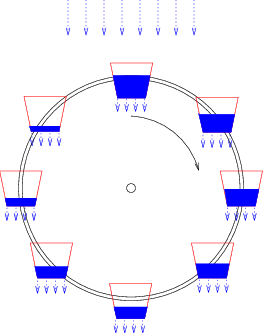

In [7]:
Image(filename="images/water-wheel.png")

<!-- lab6:fig:water-wheel -->

**Figure: The Lorenzian water wheel.**

Imagine a wheel which is free to rotate about a horizontal axis, as
depicted in [Figure water-wheel](#fig_water-wheel).



To the circumference of the wheel is attached a series of leaky buckets.
Water flows into the buckets at the top of the wheel, and as the buckets
are filled with water, the wheel becomes unbalanced and begins to
rotate. Depending on the physical parameters in this system, the wheel
may remain motionless, rotate steadily in a clockwise or
counter-clockwise direction, or reverese its motion in irregular
intervals. This should begin to remind you of the type of behaviour
exhibited in the Lorenz system for various parameters.

The following are the variables and parameters in the system:

$r$: the radius of the wheel (constant),

$g$: the acceleration due to gravity (constant),

$\theta(t)$: is the angular displacement (not a fixed point on the wheel)
    (unknown),

$m(\theta,t)$: the mass of the water per unit arc, which we assume is a continuous
    function of the angle (unknown),

$\Omega(t)$:  the angular velocity of the wheel,

We also make the following assumptions:

-   water is added to the wheel at a constant rate.

-   the points on the circumference of the wheel gain water at a rate
    proportional to their height.

-   water leaks out at a rate proportional to $m$.

-   there is frictional damping in the wheel proportional to the angular
    velocity, $k \Omega$,

-   $A$, $B$, $h$ are additional positive constants.

We’ll pass over some details here, and go right to the equations of
motion. The equation describing the evloution of the angular momentum is
<!-- \label{lab6:eq:wheel1} -->

$$
\frac{d\Omega}{dt} = -k \Omega - \left( \frac{gh}{2\pi aA} \right)
  m \cos\theta.
 $$ 
 
  The requirement of conservation
  <!--  \label{lab6:eq:wheel2} -->
of mass in the system leads to two equations
$$\frac{d (m \sin\theta)}{dt} = \Omega m \cos\theta - h m \sin\theta +
    2\pi B
$$ 
<!-- \label{lab6:eq:wheel3} -->
and
$$
\frac{d (m \cos\theta)}{dt} = -\Omega m \sin\theta - h m \cos\theta,
$$ 
(where all variables dependent on the angle
have been averaged over $\theta$).

Using a suitable change of variables, these three equations
can be written in the same form as the
Lorenz equations (with $\beta=1$).

<div id="sec_references"></div>

## B. References


Gleick, J., 1987: *Chaos: Making a New Science*. Penguin
Books.

Lorenz, E. N., 1963: Deterministic nonperiodic flow. *Journal of
the Atmospheric Sciences*, **20**, 130–141.

Palmer, T., 1993: A weather eye on unpredictability. in N. Hall, editor,
*Exploring Chaos: A Guide to the New Science of Disorder*,
chapter 6. W. W. Norton & Co.

Saltzman, B., 1962: Finite amplitude free convection as an initial value
problem – I. *Journal of the Atmospheric
Sciences*, **19**, 329–341.

Sparrow, C., 1982: *The Lorenz Equations: Bifurcations, Chaos, and
Strange Attractors*. volume 41 of *Applied Mathematical
Sciences*. Springer-Verlag.
